In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Preprocessing

In [2]:
df = pd.read_csv('fen_analysis.csv').sample(frac=1)[:30000] # This shuffles the rows
df

,fen_value,score
289879,r5k1/p2n2pp/Qpp5/3p3n/3P4/P7/KP2R3/5q2 w - - 2 32,-499
274379,r1b1kbr1/ppppqp1p/6p1/8/8/2P1QN2/P1P1PPPP/R3KB...,-83
313809,rnbqkbnr/pppp1ppp/8/4p3/8/2NP4/PPP1PPPP/R1BQKB...,35
120459,8/7k/7p/1p2N1P1/5p1P/P1n3K1/2P5/5r2 w - - 0 45,-417
53645,r4rk1/1b1nqpb1/2pp2pp/1p6/p3PQP1/P2PNN2/BPP2P2...,-101
...,...,...
161873,r1bqk2r/3pbp2/p6p/1pp1P1p1/6n1/P1N2Q2/BPP2PPP/...,-329
241576,3r3r/2p1kp1P/p1Q5/6pR/6b1/4P1b1/PPNP2B1/R1BK2N...,790
48059,1qr3k1/5pp1/R6p/8/8/1P3QPP/2r1R2K/8 b - - 4 36,463
98657,3r1rk1/p5pp/1b6/2pq4/2Rp1P2/PP2pQ2/1B4PP/5NK1 ...,-515


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings, dtype=torch.float32)

In [7]:
X.shape, y.shape

(torch.Size([30000, 70]), torch.Size([30000]))

# Helper Functions

In [8]:
val_split = 10000
test_split = 10000

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.bfloat16)
    return x, y
# b = get_batch(X, y, 64)

In [11]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:test_split].to(device)
y_test = y[val_split:test_split].to(device)
X = X[test_split:]
y = y[test_split:]

# Training

In [12]:
# hyperparameters
lr = 0.01
num_steps = 3000
warmup_steps = 250
bs = len(X)
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs > len(X): bs = len(X)

In [13]:
from torch.optim.lr_scheduler import LambdaLR


In [14]:
model = MLPEngine(embedding_dim=64).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = lr)
# Define warm-up and decay
def lr_lambda(epoch):
    if epoch < warmup_steps:  
        return epoch / warmup_steps
    else:  # Exponential decay after warm-up
        return 0.95 ** (epoch - warmup_steps)

scheduler = LambdaLR(optimiser, lr_lambda)
model = model.to(torch.bfloat16)
model.compile()

In [15]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [16]:
train_history = {}
val_history = {}
start_step = 0

In [17]:
model.train()
# train_history = {}
# val_history = {}
for step_i in range(num_steps):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs) 
    # print(x_batch, y_batch)
    y_pred = model(x_batch).view(bs)
    # print(y_pred.shape, y_batch.shape)
    loss = loss_category(y_pred, y_batch)
    # print(loss.item())
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    # print(f"Epoch {step_i}, Learning Rate: {scheduler.get_last_lr()}")
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0:
        # validation phase
        y_pred = model(X_val).view(val_split)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_category(y_pred, y_val)
        # print(loss.item())
        val_history[tot_step] = loss.item()

start_step += num_steps

0 :  3178496.0
1 :  3244032.0
2 :  3293184.0
3 :  3555328.0
4 :  3309568.0
5 :  3293184.0
6 :  3260416.0
7 :  3555328.0
8 :  3145728.0
9 :  3227648.0
10 :  3227648.0
11 :  3309568.0
12 :  3325952.0
13 :  3211264.0
14 :  3293184.0
15 :  3342336.0
16 :  3325952.0
17 :  3325952.0
18 :  3325952.0
19 :  3129344.0
20 :  3244032.0
21 :  3440640.0
22 :  3325952.0
23 :  3244032.0
24 :  3391488.0
25 :  3358720.0
26 :  3506176.0
27 :  3276800.0
28 :  3162112.0
29 :  3096576.0
30 :  3162112.0
31 :  3424256.0
32 :  3276800.0
33 :  3194880.0
34 :  3260416.0
35 :  3358720.0
36 :  3325952.0
37 :  3424256.0
38 :  3211264.0
39 :  3325952.0
40 :  3473408.0
41 :  3031040.0
42 :  3457024.0
43 :  3194880.0
44 :  3489792.0
45 :  3342336.0
46 :  3325952.0
47 :  3145728.0
48 :  3227648.0
49 :  3227648.0
50 :  3063808.0
51 :  3309568.0
52 :  3342336.0
53 :  3325952.0
54 :  3260416.0
55 :  3325952.0
56 :  3178496.0
57 :  3325952.0
58 :  3375104.0
59 :  3325952.0
60 :  3325952.0
61 :  3375104.0
62 :  3325952.0
63

KeyboardInterrupt: 

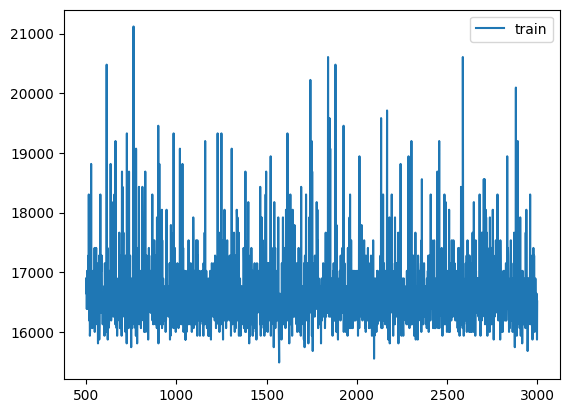

In [ ]:
plt.plot(list(train_history.keys())[500:], list(train_history.values())[500:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

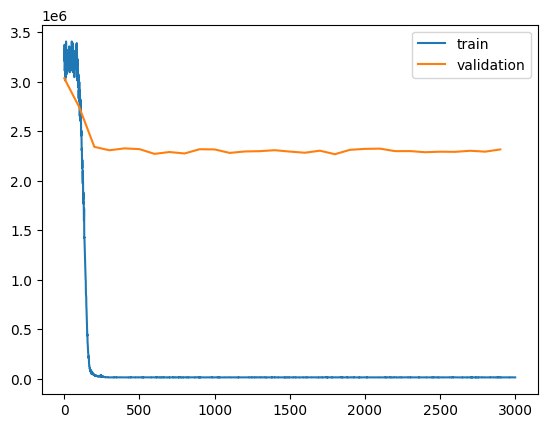

In [ ]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [ ]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

'\n# My results\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n\nAdam is better than AdamW for this task\n'

# Inference

In [ ]:
fen_sample ='rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'

In [ ]:
def get_score(fen_sample):
    # encoding
    encoder_object = ChessEncoder()
    encoded_fen = torch.tensor(encoder_object.encode_fen(fen_i), dtype=torch.int32).to(device).view(70)
    # print(encoded_fen.shape)
    bs=1
    model = MLPEngine(embedding_dim=32).to(device)
    model.eval()
    y_pred = model(encoded_fen)
    return y_pred.item()
    # run the model

In [ ]:
get_score(fen_sample)

1.7990574836730957

# TODO
- [x] do inference
- [ ] look for other/ better dataset
- [ ] add regularisation
- [x] add proper initialisation
- [ ] Then start to think about architectural changes
- [ ] do some hyperparameter tuning, maybe grid search or something
  - [ ] **learning rate scheduler
  - [ ] embedding dimension changes
  - [ ] model neurons ++
  - [ ] **batch/ layer normalisation
  - [ ] different precision
  - [ ] custom loss function of the specific problem
  - [ ] Check for potential gradient vanishing/exploding

current precision is giving loss as int, fix it